# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [7]:
 # define your regions here
presel = {
        "mu": {
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
        },
        "ele": {
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
    "WZQQorDYJets"
]

samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [8]:
events_dict = {}

In [58]:
taggers = [
    "v2_nor2",
#     "v35_1_1",
#     "v35_1_2",
#     "v35_2_1",
#     "v35_2_4",
#     "v35_2_5",
    "v35_2_6",
#     "v35_3_1",
#     "v35_3_2",
#     "v35_3_3",    
#     "v35_4_1",
#     "v35_4_2",
#     "v35_4_3",    

    "v35_5_4",
    
#     "v35_6_1",
#     "v35_6_2",
#     "v35_6_3",
#     "v35_6_4",
#     "v35_6_5",
    
    "v35_7_1",
#     "v35_7_2",
#     "v35_7_3", 
    
#     "v35_8_1",
#     "v35_8_2",
#     "v35_8_3",  
    
    "v35_10_1",
    "v35_10_2",
    "v35_10_3",  
    "v35_10_4",  
    "v35_10_5", 
    
    "v35_11_1",
    "v35_11_2",
    "v35_11_3",
    "v35_11_4",    
]


for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1663 events
INFO:root:Will fill the VBF dataframe with the remaining 1056 events
INFO:root:tot event weight 8.986915818511086 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 69 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2 events
INFO:root:tot event weight 3.2085493332261086 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1897 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 344 events
INFO:root:tot event weight 105.54188192262322 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine t

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 111882 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 23240 events
INFO:root:tot event weight 1254.6445963586352 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 355362 events
INFO:root:Will fill the TTbar dataframe with the remaining 27390 events
INFO:root:tot event weight 3164.774857411814 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 23539 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1157 events
INFO:root:tot event weight 33.682583820996285 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored even

INFO:root:Will fill the TTbar dataframe with the remaining 8529 events
INFO:root:tot event weight 287.2968088322185 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 261 events
INFO:root:Will fill the QCD dataframe with the remaining 1 events
INFO:root:tot event weight 8.520716772407798e-05 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 88 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 15 events
INFO:root:tot event weight 0.6034503172086644 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 70 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5 events
INFO:root:tot even

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 709 events
INFO:root:Will fill the QCD dataframe with the remaining 16 events
INFO:root:tot event weight 0.03934717117848666 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2479 events
INFO:root:Will fill the VBF dataframe with the remaining 1759 events
INFO:root:tot event weight 14.547485642612212 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 79 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8 events
INFO:root:tot event weight 13.175776825818003 

INFO:root:Finding EWKWminus_WToLNu samples and should combine the

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 148852 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 36873 events
INFO:root:tot event weight 2012.4104307155308 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 375217 events
INFO:root:Will fill the TTbar dataframe with the remaining 32358 events
INFO:root:tot event weight 3724.0755887090013 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 34606 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1682 events
INFO:root:tot event weight 47.574485167005804 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored eve

INFO:root:Will fill the TTbar dataframe with the remaining 8023 events
INFO:root:tot event weight 268.95194575474613 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 149 events
INFO:root:Will fill the QCD dataframe with the remaining 7 events
INFO:root:tot event weight 0.0004738240975623906 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 63 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 13 events
INFO:root:tot event weight 0.4961862326150443 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 61 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 8 events
INFO:root:tot eve

INFO:root:tot event weight 0.1402000024299263 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 35806 events
INFO:root:Will fill the Data dataframe with the remaining 6988 events
INFO:root:tot event weight 6988.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1514 events
INFO:root:Will fill the VBF dataframe with the remaining 987 events
INFO:root:tot event weight 12.958180850131882 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 34 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5 events
INFO:root:tot event weight 10.851796020386798 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EW

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 159607 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 32972 events
INFO:root:tot event weight 1829.8447734867516 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 349864 events
INFO:root:Will fill the TTbar dataframe with the remaining 26759 events
INFO:root:tot event weight 4401.249786146961 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 31158 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1466 events
INFO:root:tot event weight 46.428525196833114 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To25

INFO:root:tot event weight 7.111351761134137 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 629 events
INFO:root:Will fill the TTbar dataframe with the remaining 85 events
INFO:root:tot event weight 18.69068032377287 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1090 events
INFO:root:Will fill the QCD dataframe with the remaining 50 events
INFO:root:tot event weight 1.111936731176413 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 841 events
INFO:root:Will fill the QCD dataframe with the remaining 73 events
INFO:root:tot event weight 33.56592469852006 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them unde

INFO:root:tot event weight 0.07401378435293611 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2336 events
INFO:root:Will fill the VBF dataframe with the remaining 1603 events
INFO:root:tot event weight 21.299008052688436 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 58 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6 events
INFO:root:tot event weight 12.921947429232027 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2134 events
INFO:root:Will fill the EWKvjets dataframe with t

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 210651 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 51745 events
INFO:root:tot event weight 2945.272296727413 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 366309 events
INFO:root:Will fill the TTbar dataframe with the remaining 31809 events
INFO:root:tot event weight 5310.201603516829 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 44464 events
INFO:root:Will fill the SingleTop dataframe with the remaining 2243 events
INFO:root:tot event weight 72.01512196970234 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 129 events
INFO:root:Will fill the Diboson dataframe with the remaining 29 events
INFO:root:tot event weight 7.477550098032906 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1386 events
INFO:root:Will fill the TTbar dataframe with the remaining 267 events
INFO:root:tot event weight 58.263111473685974 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1111 events
INFO:root:Will fill the QCD dataframe with the remaining 112 events
INFO:root:tot event weight 2.489386364915487 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event 

INFO:root:Applying tagger>0.5 selection on 16683 events
INFO:root:Will fill the Data dataframe with the remaining 3206 events
INFO:root:tot event weight 3206.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 784 events
INFO:root:Will fill the VBF dataframe with the remaining 502 events
INFO:root:tot event weight 3.7793306140385057 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 16 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Finding EWKWminus_WToLNu samples and should comb

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying tagger>0.5 selection on 42945 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7869 events
INFO:root:tot event weight 447.62740487732606 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 353131 events
INFO:root:Will fill the TTbar dataframe with the remaining 27685 events
INFO:root:tot event weight 1268.8263467592462 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 17638 events
INFO:root:Will fill the Data dataframe with the remaining 2569 events
INFO:root:tot event weight 2569.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 10797 events
INFO:root:Will fill the SingleTop dataframe with the remaining 

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 39 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5 events
INFO:root:tot event weight 1.6593925926418993 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 60 events
INFO:root:Will fill the Diboson dataframe with the remaining 3 events
INFO:root:tot event weight 0.8763711539873902 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 712 events
INFO:root:Will fill the TTbar dataframe with the remaining 84 events
INFO:root:tot event weight 5.691843630872283 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1136 events
INFO:root:Wi

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 21545 events
INFO:root:Will fill the Data dataframe with the remaining 4239 events
INFO:root:tot event weight 4239.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 1050 events
INFO:root:Will fill the Data dataframe with the remaining 196 events
INFO:root:tot event weight 196.0 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1089 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 266 events
INFO:root:tot event weight 59.51544323916119 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding SingleMuon_Run2016G samples

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1499 events
INFO:root:Will fill the WH dataframe with the remaining 1037 events
INFO:root:tot event weight 0.9656476477134773 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 60046 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14300 events
INFO:root:tot event weight 811.9567122227203 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 393726 events
INFO:root:Will fill the TTbar dataframe with the remaining 36189 events
INFO:root:tot event weight 1614.8000436935854 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should c

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 47 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 6 events
INFO:root:tot event weight 3.0038324867197836 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 32 events
INFO:root:Will fill the Diboson dataframe with the remaining 7 events
INFO:root:tot event weight 1.5514581208415898 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1629 events
INFO:root:Will fill the TTbar dataframe with the remaining 282 events
INFO:root:tot event weight 16.061797119173477 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using a

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 983 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 162 events
INFO:root:tot event weight 42.93030682946239 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1032 events
INFO:root:Will fill the WH dataframe with the remaining 596 events
INFO:root:tot event weight 0.4571723943457689 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying tagger>0.5 selection on 50985 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 9558 events
INFO:root:tot event weight 491.9786366000948 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 326351 events
INFO:root:Will fill the TTbar dataframe with the remaining 26524 events
INFO:root:tot event weight 1387.9117281853437 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 9112 events
INFO:root:Will fill the SingleTop dataframe with the remaining 450 events
INFO:root:tot event weight 14.454179794419954 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INF

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 9 events
INFO:root:tot event weight 2.9970475800966283 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 88 events
INFO:root:Will fill the Diboson dataframe with the remaining 9 events
INFO:root:tot event weight 2.2239442717632736 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 792 events
INFO:root:Will fill the TTbar dataframe with the remaining 123 events
INFO:root:tot event weight 6.513246903323722 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 982 events
INFO:root:Will fill the QCD dataframe with the remaining 32 events
INFO:root:tot event weight 0.2346619533315027 


INFO:root:tot event weight 8.157948362148234 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 701 events
INFO:root:Will fill the QCD dataframe with the remaining 20 events
INFO:root:tot event weight 0.021417973122376373 

INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 13038 events
INFO:root:Will fill the Data dataframe with the remaining 2098 events
INFO:root:tot event weight 2098.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 816 events
INFO:root:Will fill the VBF dataframe with the remaining 571 events
INFO:root:tot event weight 6.562667379565042 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them un

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 73854 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 17555 events
INFO:root:tot event weight 908.1540576664222 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 368486 events
INFO:root:Will fill the TTbar dataframe with the remaining 35751 events
INFO:root:tot event weight 1857.22146116768 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 13314 events
INFO:root:Will fill the SingleTop dataframe with the remaining 722 events
INFO:root:tot event weight 22.70840025510929 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 sa

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5 events
INFO:root:tot event weight 1.4671371359461285 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 37 events
INFO:root:Will fill the Diboson dataframe with the remaining 6 events
INFO:root:tot event weight 1.5926499925310602 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1921 events
INFO:root:Will fill the TTbar dataframe with the remaining 397 events
INFO:root:tot event weight 22.390136399998173 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1127 events
INFO:root:Will fill the QCD dataframe with the remaining 133 events
INFO:root:tot event weight 0.96373716039703

INFO:root:Applying tagger>0.5 selection on 414 events
INFO:root:Will fill the Diboson dataframe with the remaining 139 events
INFO:root:tot event weight 15.064100931037839 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 773 events
INFO:root:Will fill the QCD dataframe with the remaining 60 events
INFO:root:tot event weight 0.06283756000744974 

INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data


In [52]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    if "v2_nor2" in tagger:
        taggerss.append(f"fj_ParT_score_finetuned")        
    else:
        taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [53]:
signals = ["VBF", "ggF"]
# signals += ["ttH", "WH", "ZH"]

tagger_cuts = np.linspace(0.9, 0.999, 30)
# tagger_cuts = np.linspace(0.9, 0.975, 20)

mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["mu"]

s_over_b = {}

den, num = 0, 0
for tagger in taggerss:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]
                    df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    df = df[(df["n_bjets_T"]==0)]                      
                        
                    if sample == "QCD":
                        threshold = 30
                        den += len(df['event_weight'])
                        num += sum(df["event_weight"]>threshold)

                        df = df[df["event_weight"] < threshold]

                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.9034137931034483
tagger cut 0.9068275862068965
tagger cut 0.9102413793103449
tagger cut 0.9136551724137931
tagger cut 0.9170689655172414
tagger cut 0.9204827586206896
tagger cut 0.923896551724138
tagger cut 0.9273103448275862
tagger cut 0.9307241379310345
tagger cut 0.9341379310344827
tagger cut 0.9375517241379311
tagger cut 0.9409655172413793
tagger cut 0.9443793103448276
tagger cut 0.9477931034482758
tagger cut 0.9512068965517242
tagger cut 0.9546206896551724
tagger cut 0.9580344827586207
tagger cut 0.9614482758620689
tagger cut 0.9648620689655173
tagger cut 0.9682758620689655
tagger cut 0.9716896551724138
tagger cut 0.975103448275862
tagger cut 0.9785172413793104
tagger cut 0.9819310344827586
tagger cut 0.9853448275862069
tagger cut 0.9887586206896551
tagger cut 0.9921724137931034
tagger cut 0.9955862068965518
tagger cut 0.999
TAGGER: fj_ParT_score_finetuned
tagger cut 0.9
tagger cut 0.9034137931034483
tagger cut 0.9068275862068965
t

tagger cut 0.9034137931034483
tagger cut 0.9068275862068965
tagger cut 0.9102413793103449
tagger cut 0.9136551724137931
tagger cut 0.9170689655172414
tagger cut 0.9204827586206896
tagger cut 0.923896551724138
tagger cut 0.9273103448275862
tagger cut 0.9307241379310345
tagger cut 0.9341379310344827
tagger cut 0.9375517241379311
tagger cut 0.9409655172413793
tagger cut 0.9443793103448276
tagger cut 0.9477931034482758
tagger cut 0.9512068965517242
tagger cut 0.9546206896551724
tagger cut 0.9580344827586207
tagger cut 0.9614482758620689
tagger cut 0.9648620689655173
tagger cut 0.9682758620689655
tagger cut 0.9716896551724138
tagger cut 0.975103448275862
tagger cut 0.9785172413793104
tagger cut 0.9819310344827586
tagger cut 0.9853448275862069
tagger cut 0.9887586206896551
tagger cut 0.9921724137931034
tagger cut 0.9955862068965518
tagger cut 0.999
TAGGER: fj_ParT_score_finetuned_v35_11_1
tagger cut 0.9
tagger cut 0.9034137931034483
tagger cut 0.9068275862068965
tagger cut 0.9102413793103449

In [57]:
plt.rcParams.update({"font.size": 20})

channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(15, 14))

taggers_to_plot = [
    "fj_ParT_score",
    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_1",
    "fj_ParT_score_finetuned_v35_2_6",
    "fj_ParT_score_finetuned_v35_5_4",    


    "fj_ParT_score_finetuned_v35_11_1",
    "fj_ParT_score_finetuned_v35_11_2",
    "fj_ParT_score_finetuned_v35_11_3",
    "fj_ParT_score_finetuned_v35_11_4",    
]
# taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    if tagger == "fj_ParT_score_finetuned":
        lab = "fj_ParT_score_finetuned (current)"
        col = "tab:orange"
        
#     elif tagger == "fj_ParT_score_finetuned_v35_2_6":
#         lab = "fj_ParT_score_finetuned (new)"

    elif tagger == "fj_ParT_score_finetuned_v35_2_6":
        lab = "Option 1"   
        col = "tab:cyan"
        
        
    elif tagger == "fj_ParT_score_finetuned_v35_5_4":
        lab = "Option 2"    
        col = "tab:purple"
        
    elif tagger == "fj_ParT_score_finetuned_v35_7_1":
        lab = "Option 3"
        col = "green"

        
    else:
        lab = tagger
        col = "tab:blue"
        
    
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab)#, c=col)

ax.legend(loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

ax.axvline(0.975, linestyle="--", color="grey")
ax.axvline(0.947, linestyle="--", color="grey")
# ax.axvline(0.965, linestyle="--", color="grey")

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

SyntaxError: EOL while scanning string literal (2453183294.py, line 31)

In [172]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [191]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
    "ttH",
    "WH",
    "ZH",    
#     "QCD",
#     "DYJets",
    "WJetsLNu",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",

#     "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
    "WZQQorDYJets"
]

In [192]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
tagger = "fj_ParT_score_finetuned_v35_5_4"

tagger_cut = 0.95
# tagger_cut = 0.9
presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
#     "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
    "SR": f"{tagger}>0.965",
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2016APV"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utilsAN

massbin = 10
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
        )    
    elif var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"ParT regressed mass [GeV]", overflow=True)
        )              
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utilsAN.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
#                 if sample == "DYJets":
#                     continue  
#                 if sample == "WJetsLNu":
#                     df = ev[year][ch][sample]
#                     df = pd.concat([df, ev[year][ch]["DYJets"]])
#                 else:
#                     df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = ev[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
#                     df = ev[year][ch][sample]
        
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "QCD":
#                     threshold = 30
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                
                
                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_misolation"]
                        
                    else:
                        continue

                else:
                    x = df[var]
                    
#                 if var == "lep_eta":
#                     x = np.absolute(df[var])
                
#                 df = df[np.absolute(df["lep_eta"])<0.5]
#                 x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot rec_higgs_m histogram


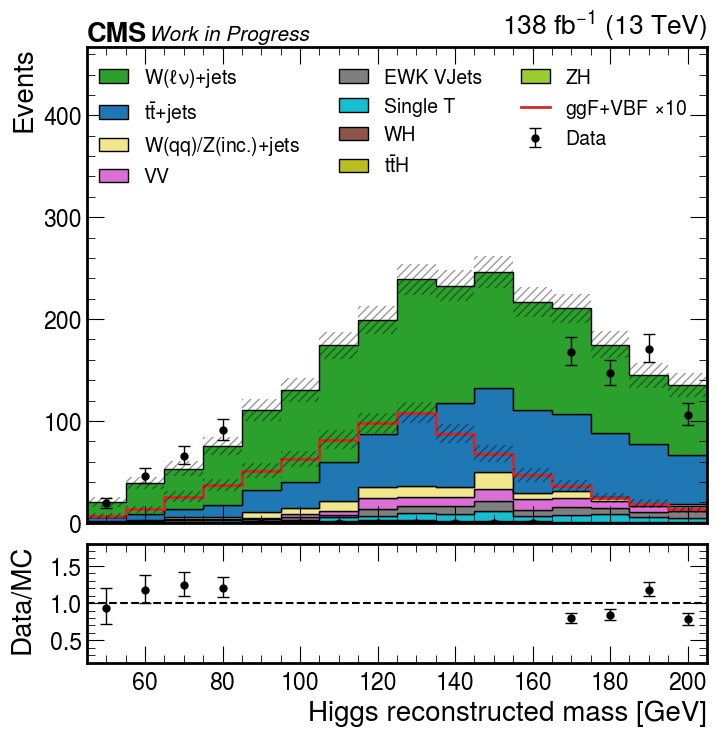

In [193]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=[90,160]
    mult=10
    
    
from utils import plot_hists
if len(years) > 1:
    from utilsF import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utilsAN import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
# get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [62]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "UES_down"


a = ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

d = ax.hist(df[f"rec_higgs_m{syst}"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

# w = (df[f"rec_higgs_m{syst}"]/df["rec_higgs_m"])
# ax.hist(df[f"rec_higgs_m"], label="(should be down)", weights=df["weight_ele"] * w,
#         bins=bins, lw=1, histtype="step", 
#        )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")